# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.085634,False,-4.084557
1,-1.418167,False,-4.159834
2,-1.060908,False,-1.876372
3,-0.040109,True,4.739495
4,-1.135199,False,-2.126015
...,...,...,...
995,0.167694,True,6.002419
996,-1.342202,False,-5.061231
997,-1.115815,False,-4.549248
998,0.224101,False,2.319660


<Axes: xlabel='v0'>

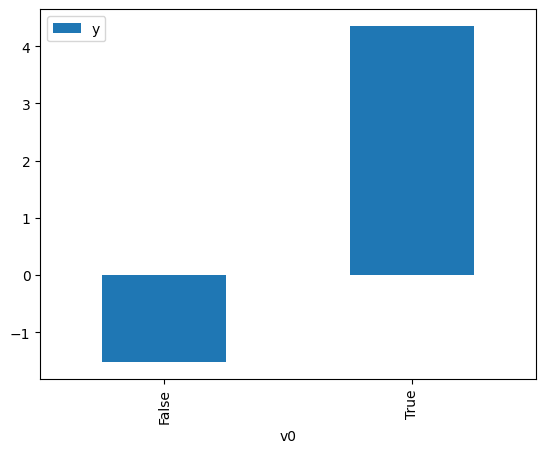

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

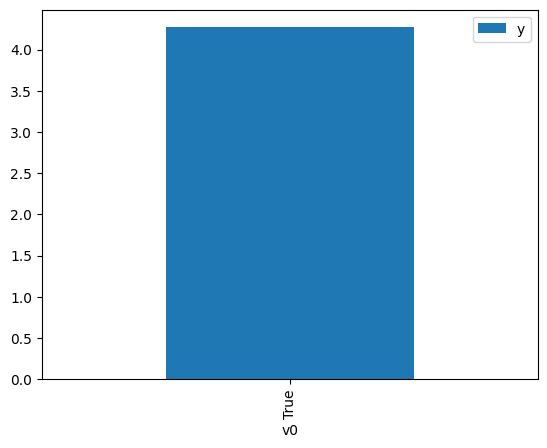

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.550093,False,-1.532310,0.756892,1.321192
1,-0.722684,False,-1.846021,0.810431,1.233912
2,-1.996264,False,-6.116133,0.977962,1.022534
3,-0.525880,False,-0.314164,0.748614,1.335802
4,-0.668037,False,-3.078179,0.794523,1.258616
...,...,...,...,...,...
995,-2.188685,False,-5.719837,0.984423,1.015824
996,0.607096,False,0.420697,0.270844,3.692155
997,-0.310138,False,-0.762520,0.667047,1.499146
998,-1.141617,False,-4.197842,0.902252,1.108338


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.568209,True,3.579572,0.237036,4.218773
1,-0.506941,True,3.209480,0.257991,3.876099
2,0.701984,True,7.612798,0.762181,1.312024
3,-0.486111,True,4.661744,0.265385,3.768110
4,0.228094,True,5.046634,0.572979,1.745264
...,...,...,...,...,...
995,-0.472540,True,2.449277,0.270274,3.699946
996,-1.012103,True,1.651103,0.120835,8.275773
997,-1.472749,True,0.877186,0.055678,17.960356
998,-0.103875,True,3.710211,0.421676,2.371490


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.062e+04
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                        0.00
Time:                        18:29:21   Log-Likelihood:                         -1426.4
No. Observations:                1000   AIC:                                      2857.
Df Residuals:                     998   BIC:                                      2867.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7773      0.030     93.411      0.000       2.719       2.836
x2             5.0002      0.054     91.951      0.000       4.894       5.107
==============================================================================
Omnibus:                        2.397   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.464
Skew:                          -0.105   Prob(JB):                        0.292
Kurtosis:                       2.878   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""